# <font color='brown'>Setup </font>

In [1]:
%%time
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm
from matplotlib import pyplot as plt
import seaborn as sns

Wall time: 1.09 s


In [2]:
def get_current_folder():
    return os.getcwd().split("\\")[-1]

In [3]:
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
df = pd.read_csv('{}combined_csv.csv'.format(path))

In [4]:
df.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_duelists,DEF_sentinels,DEF_controllers,ATK_Shields,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,315892,1,0,2500,0,5,5,0,0,0,...,1,2,1,0,100,Haven,20000,10448,1,0
1,315892,1,21250,2500,0,5,4,0,0,21,...,0,2,1,0,75,Haven,20000,10448,1,0
2,315892,1,21911,2000,0,4,4,0,0,22,...,0,2,1,0,75,Haven,20000,10448,1,0
3,315892,1,23629,1500,0,3,4,0,0,24,...,0,2,1,0,75,Haven,20000,10448,1,0
4,315892,1,25601,1000,0,2,4,0,0,26,...,0,2,1,0,75,Haven,20000,10448,1,0


In [5]:
df.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

In [6]:
df = df[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive", "DEF_has_OP", "Def_has_Odin",
         "RegularTime", "SpikeTime", "MapName", "FinalWinner"]]
df = pd.get_dummies(df, columns=['MapName'])

In [7]:
X = df.drop(['FinalWinner'], axis='columns')
Y = df.FinalWinner
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)

In [8]:
%%time
params = pd.read_csv('model_params.csv', index_col=False)
params = params.to_dict('records')[0]
params

Wall time: 7.98 ms


{'bagging_freq': 10,
 'min_data_in_leaf': 73,
 'max_depth': 13,
 'learning_rate': 0.0998848376926905,
 'num_leaves': 70,
 'num_threads': 3,
 'min_sum_hessian_in_leaf': 8}

In [9]:
model = lightgbm.LGBMClassifier(bagging_freq=params["bagging_freq"], min_data_in_leaf=params["min_data_in_leaf"],
                                max_depth=params["max_depth"],
                                learning_rate=params["learning_rate"], num_leaves=params["num_leaves"],
                                num_threads=params["num_threads"], min_sum_hessian_in_leaf=params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


LGBMClassifier(bagging_freq=10, learning_rate=0.0998848376926905, max_depth=13,
               min_data_in_leaf=73, min_sum_hessian_in_leaf=8, num_leaves=70,
               num_threads=3)

# <font color='brown'>Dataframe </font>

In [19]:
match = 26426
series = 13189

In [20]:
import os
from webscrapping.series_scrap import RIBScrapper
from webscrapping.analyse_json import Analyser
rb = RIBScrapper()
existing_file = rb.existing_file("{}.csv".format(match))

if not existing_file:
    download_link = rb.generate_single_link(series, match)
    rb.export_json(download_link)
    
    a = Analyser("{}.json".format(match))
    matchframe = a.export_df(match)
    matchframe.to_csv(r'matches\exports\{}.csv'.format(match), index=False)

In [21]:
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\exports\\'
df = pd.read_csv('{}{}.csv'.format(path2,match))

In [22]:
df.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,414364,1,0,400.0,400.0,5,5,0,0,0,...,1,1,2,1,1,Ascent,26426,13189,3,1
1,414364,1,5830,300.0,400.0,4,5,0,0,6,...,1,1,2,1,1,Ascent,26426,13189,3,1
2,414364,1,16279,300.0,300.0,4,4,0,0,16,...,1,1,1,1,1,Ascent,26426,13189,3,1
3,414364,1,17733,300.0,200.0,4,3,0,0,18,...,1,1,0,1,1,Ascent,26426,13189,3,1
4,414364,1,30605,300.0,200.0,4,2,0,0,31,...,1,1,0,0,1,Ascent,26426,13189,3,1


In [23]:
from typing import List

class RoundReplay:
    def __init__(self, match_id: int, df: pd.DataFrame, model):
        self.match_id = match_id
        self.query = df.query('MatchID == {}'.format(match_id))
        self.round_table = self.get_round_table()
        self.df = df
        self.model = model

    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))

    def get_round_winners(self) -> dict:
        g = self.query[["RoundNumber", "FinalWinner"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.FinalWinner))

    def get_round_id(self, round_index: int) -> int:
        return self.round_table[round_index]

    def get_round_dataframe(self, round_index: int):
        return self.df.query('RoundID == {}'.format(self.get_round_id(round_index)))

    def get_plant_stamp(self, round_number: int) -> int or None:
        rdf = self.get_round_dataframe(round_number)
        if max(rdf.SpikeTime) == 0:
            return None
        for i in rdf.iterrows():
            current_index = i[0]
            current_time = i[1].RegularTime
            next_time = tuple(rdf["RegularTime"].loc[[current_index + 1]])[0]
            if current_time != 0 and next_time == 0:
                return round(tuple(rdf["RoundTime"].loc[[current_index]])[0] / 1000, 0)
        return None

    def get_round_probability(self, round_number: int, **kwargs):
        old_table = self.get_round_dataframe(round_number)
        table = old_table[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive",
                           "DEF_has_OP", "Def_has_Odin",
                           "RegularTime", "SpikeTime", "MapName"]]
        current_map = table.MapName.max()
        map_names = ["Ascent", "Bind", "Breeze", "Haven", "Icebox", "Split"]
        map_names.remove(current_map)
        table = pd.get_dummies(table, columns=['MapName'])
        for item in map_names:
            table['MapName_{}'.format(item)] = 0
        side = kwargs["side"]
        attack_pred = None
        if side == "atk":
            attack_pred = [round(i[1] * 100, 2) for i in self.model.predict_proba(table)]
        elif side == "def":
            attack_pred = [100 - round(i[1] * 100, 2) for i in self.model.predict_proba(table)]
        table["Attack_win_probability"] = attack_pred
        raw_timings = [int(round(x / 1000, 0)) for x in old_table.RoundTime]
        table["Round time"] = raw_timings
        return table[["Round time", "Attack_win_probability"]]

    def get_atk_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        atk_scores = []

        for i in dfm[:12]:
            if i == 1:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])
        for j in dfm[12:24]:
            if j == 0:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])

        return atk_scores

    def get_def_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        def_scores = []

        for i in dfm[:12]:
            if i == 0:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])
        for j in dfm[12:24]:
            if j == 1:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])

        return def_scores

    def get_match_winner(self) -> int:
        atks = self.get_atk_scores()
        defs = self.get_def_scores()

        winner = 0
        if atks[-1] == 12 and defs[-1] == 12:
            winner = 2
        elif atks[-1] == 13:
            winner = 1
        elif defs[-1] == 13:
            winner = 0
        return winner

    def plot_round(self, round_number: int, **kwargs):
        plt.figure(figsize=(12, 5))
        chosen_side = kwargs["side"]
        color_dict = {"atk": "red", "def": "blue"}
        round_data = self.get_round_probability(round_number, side=chosen_side)

        sns.set_context(rc={'patch.linewidth': 2.0})
        sns.set(font_scale=1.3)
        ax = sns.lineplot(x="Round time", y="Attack_win_probability", data=round_data,
                          linewidth=2.0, zorder=3, color=color_dict[chosen_side])
        ax.set(xlabel='Round time (s)', ylabel='Win probability (%)')
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 12
        ax.grid(linewidth=.4, color='gray', zorder=0)
        title_dict = {"atk": "Attack", "def": "Defense"}
        plt.title("{} win probability over time".format(title_dict[chosen_side]))
        ax.lines[0].set_marker("o")
        ax.lines[0].set_markersize(9)
        plt.axhline(y=0, color="black")
        plt.axhline(y=50, linestyle="--", color="grey")
        plant = self.get_plant_stamp(round_number)
        if plant is not None:
            plt.axvline(x=plant)

        arrow = {'facecolor': 'tab:blue', 'shrink': 0.05, 'alpha': 0.75}
        # plt.gca().annotate('nzr 2 frenzy kills', xy=(5.5, 61), xytext=(-8, 70), arrowprops=arrow, fontsize=13, color='green', weight='bold')
        # plt.gca().annotate('khalil stinger kill', xy=(16.8, 91), xytext=(-1, 90), arrowprops=arrow, fontsize=13, color='green', weight='bold')
        # plt.gca().annotate('zaks deleta o xand, \nmas o round já estava encaminhado', xy=(24, 79), xytext=(16, 60), arrowprops=arrow, fontsize=13, color='red', weight='bold')
        # plt.gca().annotate('FURIA only has 20% chance \n of winning this round', xy=(0, 17), xytext=(10, 5), arrowprops=arrow, fontsize=13, color='red', weight='bold')


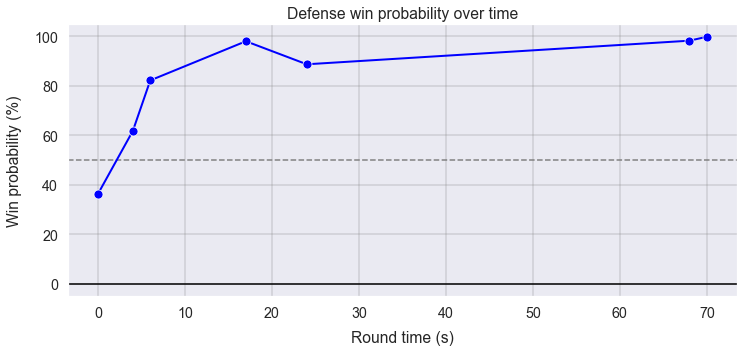

In [24]:
rr = RoundReplay(match, df, model)
rr.plot_round(7, side="def")

In [25]:
rr.get_round_probability(7, side="def")

,Round time,Attack_win_probability
52,0,36.44
53,4,61.86
54,6,82.25
55,17,98.07
56,24,88.76
57,68,98.30
58,70,99.88


In [31]:
rr.get_round_dataframe(7)

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,MapName,MatchID,SeriesID,bestOF,FinalWinner
52,414370,7,0,2900.0,740.0,5,5,0,0,0,...,1,1,2,1,1,Ascent,26426,13189,3,0
53,414370,7,3547,2320.0,740.0,4,5,0,0,4,...,1,1,2,1,1,Ascent,26426,13189,3,0
54,414370,7,6203,1740.0,740.0,3,5,0,0,6,...,1,1,2,1,1,Ascent,26426,13189,3,0
55,414370,7,16556,1160.0,740.0,2,5,0,0,17,...,1,1,2,1,1,Ascent,26426,13189,3,0
56,414370,7,23739,1160.0,640.0,2,4,0,0,24,...,1,1,1,1,1,Ascent,26426,13189,3,0
57,414370,7,67952,580.0,640.0,1,4,0,0,68,...,0,1,1,1,1,Ascent,26426,13189,3,0
58,414370,7,70044,0.0,640.0,0,4,0,0,70,...,0,1,1,1,1,Ascent,26426,13189,3,0


In [31]:
rr.get_match_winner()

0

In [51]:
r_number = pd.Series(rr.get_round_table().keys())
r_atk = pd.Series(rr.get_atk_scores())
r_def = pd.Series(rr.get_def_scores())
r_winner = pd.Series([rr.get_match_winner()] * len(r_number))
r_ids = pd.Series([rr.match_id] * len(r_number))

frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def, 'FinalWinner': r_winner}

match_frame = pd.DataFrame(frame)

In [52]:
match_frame

,MatchID,RoundNumber,AtkScore,DefScore,FinalWinner
0,26913,1,0,1,0
1,26913,2,0,2,0
2,26913,3,0,3,0
3,26913,4,0,4,0
4,26913,5,0,5,0
5,26913,6,1,5,0
6,26913,7,2,5,0
7,26913,8,2,6,0
8,26913,9,2,7,0
9,26913,10,2,8,0


https://runitback.gg/series/12745?match=25645&round=19&tab=replay

# Match

In [60]:
match = 26508
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\combined_csv.csv'
data = pd.read_csv('{}'.format(path2))

In [134]:
class MatchReplay:
    def __init__(self, match_id: int, input_df: pd.DataFrame):
        self.df: pd.DataFrame = input_df
        self.match_id: int = match_id
        self.query: pd.DataFrame = input_df.query('MatchID == {}'.format(match_id))

    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))

    def get_atk_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        atk_scores = []

        for i in dfm[:12]:
            if i == 1:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])
        for j in dfm[12:24]:
            if j == 0:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])

        return atk_scores

    def get_round_winners(self) -> dict:
        g = self.query[["RoundNumber", "FinalWinner"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.FinalWinner))

    def get_def_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        def_scores = []

        for i in dfm[:12]:
            if i == 0:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])
        for j in dfm[12:24]:
            if j == 1:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])

        return def_scores

    def get_match_winner(self) -> int:
        atks = self.get_atk_scores()
        defs = self.get_def_scores()

        winner = 0
        if atks[-1] == 12 and defs[-1] == 12:
            winner = 2
        elif atks[-1] == 13:
            winner = 1
        elif defs[-1] == 13:
            winner = 0
        return winner

    def generate_match_dataframe(self) -> pd.DataFrame:
        r_number = pd.Series(self.get_round_table().keys())
        r_atk = pd.Series(self.get_atk_scores())
        r_def = pd.Series(self.get_def_scores())
        r_winner = pd.Series([self.get_match_winner()] * len(r_number))
        r_ids = pd.Series([self.match_id] * len(r_number))

        frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def,
                 'FinalWinner': r_winner}

        d_frame = pd.DataFrame(frame)
        d_frame.dropna()

        return d_frame

    def get_all_matches(self) -> set:
        return set(self.df.MatchID)
    
    def get_atk_bank(self):
        return [
            max(self.query.query('RoundNumber == {}'.format(r)).ATK_bank)
            for r in self.get_round_table().keys()
        ]

    def get_big_dataframe(self):
        df_list = []
        match_indexes = list(self.get_all_matches())

        for i in match_indexes:
            self.match_id = i
            self.query: pd.DataFrame = self.df.query('MatchID == {}'.format(i))
            df_list.append(self.generate_match_dataframe())

        merged = pd.concat(df_list)
        merged.dropna(inplace=True)
        merged["AtkScore"] = merged["AtkScore"].astype(int)
        merged["DefScore"] = merged["DefScore"].astype(int)

        return merged

    def export_big_dataframe(self):
        big_df = self.get_big_dataframe()
        big_df.to_csv(r'matches\rounds\matches_csv.csv', index=False)
        
mr = MatchReplay(match, data)

In [132]:
%%time
qq = mr.get_big_dataframe()
qq

Wall time: 15.2 s


,MatchID,RoundNumber,AtkScore,DefScore,FinalWinner
0,24579,1,0,1,1
1,24579,2,0,2,1
2,24579,3,0,3,1
3,24579,4,0,4,1
4,24579,5,1,4,1
...,...,...,...,...,...
17,24572,18,8,10,0
18,24572,19,8,11,0
19,24572,20,8,12,0
20,24572,21,9,12,0


In [136]:
mr.get_atk_bank()

[300,
 2100,
 7500,
 4000,
 10500,
 20000,
 25900,
 25600,
 14200,
 13400,
 23300,
 26400,
 200,
 600,
 1200]

200

In [123]:
mr.generate_match_dataframe()

,MatchID,RoundNumber,AtkScore,DefScore,FinalWinner
0,24572,1,0,1,0
1,24572,2,0,2,0
2,24572,3,0,3,0
3,24572,4,0,4,0
4,24572,5,0,5,0
5,24572,6,0,6,0
6,24572,7,1,6,0
7,24572,8,1,7,0
8,24572,9,2,7,0
9,24572,10,3,7,0
